## Assignment - Syntactic Analysis

### Problem Statement

**Data**
1. For this assignment, we will use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

2. Using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

**Goal**
1. We will split the Treebank dataset into train and validation sets. A sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 
2. Following will be accomplished in this assignment:

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### POS Tagging, HMM & Viterbi

### 1. Exploring the Tree Bank Universal Tagset Corpus

In [1]:
#importing the required libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [2]:
#reading the tree bank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset="universal"))

In [3]:
#printing the first few sentences
print(nltk_data[:20])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
#splitting the data into train and validation set
random.seed(1234)
train_set, valid_set = train_test_split(nltk_data,train_size = 0.95, test_size = 0.05)

print(len(train_set))
print(len(valid_set))
print(train_set[:20])

3718
196
[[('At', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('time', 'NOUN'), (',', '.'), ('though', 'ADV'), (',', '.'), ('he', 'PRON'), ('chastised', 'VERB'), ('the', 'DET'), ('media', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('paying', 'VERB'), ('such', 'ADJ'), ('close', 'ADJ'), ('attention', 'NOUN'), ('to', 'PRT'), ('Japanese', 'ADJ'), ('investment', 'NOUN'), ('when', 'ADV'), ('other', 'ADJ'), ('foreign', 'ADJ'), ('countries', 'NOUN'), (',', '.'), ('notably', 'ADV'), ('Britain', 'NOUN'), (',', '.'), ('are', 'VERB'), ('acquiring', 'VERB'), ('more', 'ADJ'), ('American', 'ADJ'), ('assets', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('Any', 'DET'), ('question', 'NOUN'), ('as', 'ADP'), ('to', 'PRT'), ('why', 'ADV'), ('an', 'DET'), ('author', 'NOUN'), ('would', 'VERB'), ('believe', 'VERB'), ('0', 'X'), ('this', 'DET'), ('plaintive', 'ADJ'), (',', '.'), ('high-minded', 'ADJ'), ('note', 'NOUN'), ('of', 'ADP'), ('assurance', 'NOUN'), ('is', 'VERB'), ('necessary', 'ADJ'), ('*T*-2', 'X'), ('is', 'VERB'

In [5]:
#getting the list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
train_tagged_words[:10]

[('At', 'ADP'),
 ('the', 'DET'),
 ('same', 'ADJ'),
 ('time', 'NOUN'),
 (',', '.'),
 ('though', 'ADV'),
 (',', '.'),
 ('he', 'PRON'),
 ('chastised', 'VERB'),
 ('the', 'DET')]

In [6]:
#printing the length of tagged words in the train set
print(len(train_tagged_words))

95937


In [7]:
#tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['At', 'the', 'same', 'time', ',', 'though', ',', 'he', 'chastised', 'the']

In [8]:
#vocabulary
V = set(tokens)
print(len(V))

12111


In [9]:
#number of tags in the train_set
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
#printing the Tags
print(T)

{'DET', '.', 'NOUN', 'X', 'ADV', 'NUM', 'CONJ', 'ADJ', 'ADP', 'PRON', 'VERB', 'PRT'}


### 2. POS Tagging Algorithm - HMM

**Emission Probabilities**

In [11]:
#computing P(w/t) probability of word given tag and storing in T X V Matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
#computing the word given tag : Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return(count_w_given_tag, count_tag)

In [13]:
#some examples of the above function
#Banks
print("Banks")
print(word_given_tag("Banks", 'NOUN'))
print(word_given_tag("Banks", 'ADV'))
print(word_given_tag("Banks", 'ADJ'))
print(word_given_tag("Banks", 'PRON'))

#could
print("\n", "could")
print(word_given_tag("could", "VERB"))
print(word_given_tag("could", "NOUN"))
print(word_given_tag("could", "ADV"))
print(word_given_tag("could", "ADP"))

Banks
(3, 27557)
(0, 3006)
(0, 6101)
(0, 2584)

 could
(118, 12865)
(0, 27557)
(0, 3006)
(0, 9404)


**Transistion Probabilities**

In [14]:
#computing tag given tag: tag2(t1) given tag1(t1) which is the transistion probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index] == t1 and tags[index + 1] == t2:
            count_t2_t1 += 1
    return(count_t2_t1, count_t1)

In [15]:
#examples
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('ADV', 'VERB'))

(5318, 8331)
(4034, 27557)
(1050, 12865)


In [16]:
#p(tag|start) is same as p(tag|.)
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('DET', '.'))

(2490, 11189)
(994, 11189)
(1947, 11189)


In [17]:
#creating a t x t transistion matrix of tags
#each column is t2 and each row is t1
# thus matrix(i, j) represents p(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype = 'float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1] 

In [18]:
#printing the tags_matrix
tags_matrix

array([[5.40151261e-03, 1.76449399e-02, 6.38338745e-01, 4.58528399e-02,
        1.28435958e-02, 2.13659815e-02, 4.80134448e-04, 2.06097707e-01,
        9.60268918e-03, 3.60100833e-03, 3.85307893e-02, 2.40067224e-04],
       [1.74010187e-01, 9.31271762e-02, 2.22539991e-01, 2.72589158e-02,
        5.24622388e-02, 8.19554925e-02, 5.81821427e-02, 4.38823849e-02,
        9.02672261e-02, 6.48851544e-02, 8.88372511e-02, 2.50245770e-03],
       [1.31001193e-02, 2.40483359e-01, 2.64687747e-01, 2.87041403e-02,
        1.68741159e-02, 9.50756576e-03, 4.24211621e-02, 1.22654857e-02,
        1.77414089e-01, 4.89893695e-03, 1.46387488e-01, 4.32557985e-02],
       [5.46899848e-02, 1.63751990e-01, 6.24801256e-02, 7.45627955e-02,
        2.59141494e-02, 2.86168512e-03, 1.06518287e-02, 1.68521460e-02,
        1.44833073e-01, 5.58028631e-02, 2.03656599e-01, 1.83942765e-01],
       [6.85296059e-02, 1.35728538e-01, 3.12707908e-02, 2.32867599e-02,
        7.85096437e-02, 3.16034593e-02, 6.98602805e-03, 1.32

In [19]:
#converting the matrix to dataframe for a better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index = list(T))
tags_df

,DET,.,NOUN,X,ADV,NUM,CONJ,ADJ,ADP,PRON,VERB,PRT
DET,0.005402,0.017645,0.638339,0.045853,0.012844,0.021366,0.000480,0.206098,0.009603,0.003601,0.038531,0.000240
.,0.174010,0.093127,0.222540,0.027259,0.052462,0.081955,0.058182,0.043882,0.090267,0.064885,0.088837,0.002502
NOUN,0.013100,0.240483,0.264688,0.028704,0.016874,0.009508,0.042421,0.012265,0.177414,0.004899,0.146387,0.043256
X,0.054690,0.163752,0.062480,0.074563,0.025914,0.002862,0.010652,0.016852,0.144833,0.055803,0.203657,0.183943
ADV,0.068530,0.135729,0.031271,0.023287,0.078510,0.031603,0.006986,0.132735,0.117764,0.014637,0.344977,0.013972
NUM,0.003234,0.115260,0.352249,0.212585,0.002940,0.186122,0.014408,0.032637,0.034990,0.001176,0.018230,0.026169
CONJ,0.117375,0.036506,0.349815,0.008318,0.053604,0.042514,0.000462,0.118762,0.053604,0.058688,0.155268,0.005083
ADJ,0.004917,0.065399,0.698902,0.020488,0.004753,0.021144,0.017210,0.066874,0.076709,0.000656,0.011965,0.010982
ADP,0.325393,0.040408,0.322416,0.034772,0.013292,0.062952,0.000851,0.105274,0.016908,0.068056,0.008188,0.001489
PRON,0.008901,0.041409,0.208591,0.091718,0.033282,0.006966,0.005418,0.071981,0.022446,0.007353,0.488777,0.013158


In [20]:
#checking which is the most prominent starting Tag
tags_df.loc['.', :]

DET     0.174010
.       0.093127
NOUN    0.222540
X       0.027259
ADV     0.052462
NUM     0.081955
CONJ    0.058182
ADJ     0.043882
ADP     0.090267
PRON    0.064885
VERB    0.088837
PRT     0.002502
Name: ., dtype: float32

From the above we can notice that 'NOUN' is most frequently starting Tag followed by 'DET'

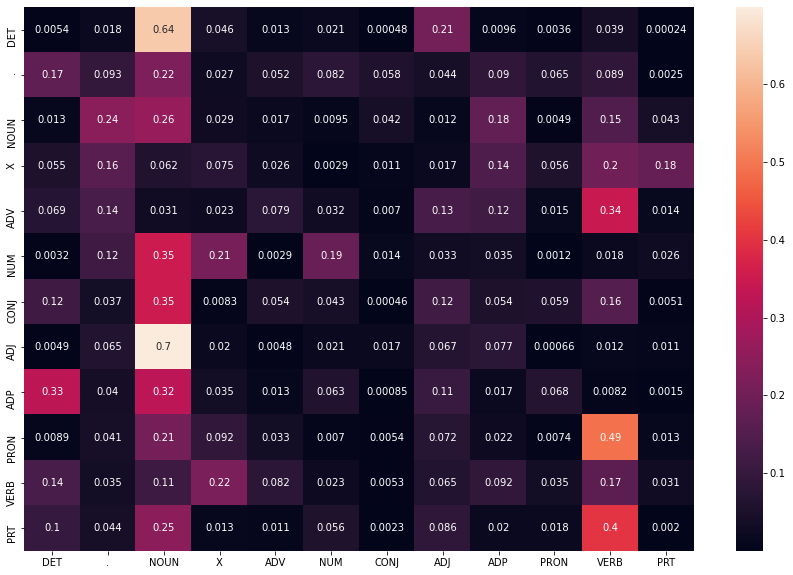

In [21]:
#heatmap of the tags matrix
plt.figure(figsize=(15,10))
sns.heatmap(tags_df, annot = True)
plt.show()

From the above heatmap we could observe the following:
1. Noun followed by Adjective is having a high proability
2. Noun followed by Determinant is also having a high probability

### 3. Viterbi Algorithm

In [22]:
len(train_tagged_words)

95937

**Vanilla Viterbi Model**

In [23]:
#Viterbi Heuristic
def viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialize list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            #computing the emission and state probabilites
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        
        pmax = max(p)
        #getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

**Evaluation on the Validation Test**

In [24]:
#running the entire test on the validation data will take a lot of time
#hence we will run our algorithm on few sample test sentences

random.seed(1234)

#choosing 10 random sentences
rndom = [random.randint(1, len(valid_set)) for x in range(10)]

#list of sentences
valid_run = [valid_set[i] for i in rndom]

#list of tagged words
valid_base = [tup for sent in valid_run for tup in sent]

#list of untagged  words
valid_tagged_words = [tup[0] for sent in valid_run for tup in sent]

In [25]:
#tagging the test sentences
start = time.time()
tagged_seq_vanilla_viterbi = viterbi(valid_tagged_words)
end = time.time()

In [26]:
difference = end-start

In [27]:
print("Time taken in seconds: ",difference)
print(tagged_seq_vanilla_viterbi)

Time taken in seconds:  47.732940435409546
[('The', 'DET'), ('1987', 'NUM'), ('statute', 'NOUN'), ('0', 'X'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('violated', 'VERB'), ('*T*-1', 'X'), ('was', 'VERB'), ('designed', 'VERB'), ('*-2', 'X'), ('*-3', 'X'), ('to', 'PRT'), ('enforce', 'VERB'), ('provisions', 'NOUN'), ('of', 'ADP'), ('South', 'NOUN'), ('Carolina', 'NOUN'), ("'s", 'PRT'), ('school-improvement', 'DET'), ('laws', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Big', 'NOUN'), ('Board', 'NOUN'), ("'s", 'PRT'), ('directors', 'NOUN'), ('meet', 'VERB'), ('today', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('approve', 'VERB'), ('some', 'DET'), ('program-trading', 'ADJ'), ('restrictions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('a', 'DET'), ('total', 'ADJ'), ('ban', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('being', 'VERB'), ('considered', 'VERB'), ('*-77', 'DET'), (',', '.'), ('Big', 'NOUN'), ('Board', 'NOUN'), ('officials', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('A', 'D

In [28]:
#checking the accuracy
check_vanilla_viterbi = [i for i, j in zip(tagged_seq_vanilla_viterbi, valid_base) if i == j]

In [29]:
accuracy_vanilla_viterbi = len(check_vanilla_viterbi) / len(tagged_seq_vanilla_viterbi)

In [30]:
#printing accuracy
print("Accuracy on the Validation Set with Vanilla Viterbi Model is: ", accuracy_vanilla_viterbi)

Accuracy on the Validation Set with Vanilla Viterbi Model is:  0.9234234234234234


In [31]:
#lets find the incorrect tagged cases
incorrect_tagged_cases = [[valid_base[i-1], j] for i, j in enumerate(zip(tagged_seq_vanilla_viterbi, valid_base)) if j[0] != j[1]]

In [32]:
incorrect_tagged_cases

[[("'s", 'PRT'),
  (('school-improvement', 'DET'), ('school-improvement', 'ADJ'))],
 [('considered', 'VERB'), (('*-77', 'DET'), ('*-77', 'X'))],
 [('breaks', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('prolonged', 'VERB'), (('sunlight', 'DET'), ('sunlight', 'NOUN'))],
 [("n't", 'ADV'), (('recyclable', 'DET'), ('recyclable', 'ADJ'))],
 [('The', 'DET'), (('Baker', 'DET'), ('Baker', 'NOUN'))],
 [('proposal', 'NOUN'), (('reasserts', 'DET'), ('reasserts', 'VERB'))],
 [('a', 'DET'), (('leading', 'ADJ'), ('leading', 'VERB'))],
 [('the', 'DET'), (('heated', 'ADJ'), ('heated', 'VERB'))],
 [('about', 'ADP'), (('much', 'ADJ'), ('much', 'ADV'))],
 [('*-1', 'X'), (('Left', 'DET'), ('Left', 'VERB'))],
 [('and', 'CONJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('barred', 'VERB'), (('*-152', 'DET'), ('*-152', 'X'))],
 [('building', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('company', 'NOUN'), (('while', 'ADP'), ('while', 'NOUN'))],
 [('*-1', 'X'), (('refocusing', 'DET'), ('refocusing', 'NOUN')

In [33]:
#totaol incorrect tagged cases
print("Total Incorrect Tagged Cases: ", len(incorrect_tagged_cases))

Total Incorrect Tagged Cases:  17


In [34]:
#lets find the unknown words from our valid_set
valid_vocabulary_set = set([t for t in valid_tagged_words])

unknown_words = list(valid_vocabulary_set - V)
print("Total Unknown Words: ", len(unknown_words))
print("Unkown Words: ", unknown_words)

Total Unknown Words:  10
Unkown Words:  ['Baker', 'refocusing', 'Left', '*-152', 'remodeling', 'sunlight', '*-77', 'recyclable', 'reasserts', 'school-improvement']


### 4. Viterbi Modification Technique - 1

In [35]:
#using transistion probability when emission probability is zero

def viterbi_modification_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialize the list of probability column for a given observation
        p = []
        p_transition = [] #list for storing transition probability
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            #computing the emission and state probability
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        #getting the state for which the probability is maximum
        state_max = T[p.index(pmax)]
        
        #if the probability is zero, then use the transition probability
        if(pmax == 0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
            
        else:
            state_max = T[p.index(pmax)]
            
        state.append(state_max)
    
    return list(zip(words, state))

**Evaluation Again of the Validation Set**

In [36]:
#tagging the test sentences
start = time.time()
tagged_seq_mod_1 = viterbi_modification_1(valid_tagged_words)
end = time.time()

In [37]:
difference = end-start

In [38]:
print("Time Taken in Seconds : ", difference)
print(tagged_seq_mod_1)

Time Taken in Seconds :  47.808629751205444
[('The', 'DET'), ('1987', 'NUM'), ('statute', 'NOUN'), ('0', 'X'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('violated', 'VERB'), ('*T*-1', 'X'), ('was', 'VERB'), ('designed', 'VERB'), ('*-2', 'X'), ('*-3', 'X'), ('to', 'PRT'), ('enforce', 'VERB'), ('provisions', 'NOUN'), ('of', 'ADP'), ('South', 'NOUN'), ('Carolina', 'NOUN'), ("'s", 'PRT'), ('school-improvement', 'VERB'), ('laws', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Big', 'NOUN'), ('Board', 'NOUN'), ("'s", 'PRT'), ('directors', 'NOUN'), ('meet', 'VERB'), ('today', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('approve', 'VERB'), ('some', 'DET'), ('program-trading', 'ADJ'), ('restrictions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('a', 'DET'), ('total', 'ADJ'), ('ban', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('being', 'VERB'), ('considered', 'VERB'), ('*-77', 'X'), (',', '.'), ('Big', 'NOUN'), ('Board', 'NOUN'), ('officials', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('A', 'D

In [39]:
#checking the accuracy
check_mod_1 = [i for i, j in zip(tagged_seq_mod_1, valid_base) if i == j]

In [40]:
accuracy_mod_1 = len(check_mod_1) / len(tagged_seq_mod_1)

In [41]:
#printing accuracy
print("Accuracy on the Validation Set of the Modified Viterbi Model is: ", accuracy_mod_1)

Accuracy on the Validation Set of the Modified Viterbi Model is:  0.9414414414414415


### 5. Viterbi Modification Technique - 2

In [42]:
#lets create a biigram tagger backed by a rule based tagger

def bigram_tagger(word, train_set = train_set):
    
    patterns = [
        (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), #any word ending with ing, ed and es is a verb
        (r'.*ly$','ADV'), #any word ending with ly, we have categorized them as a adverb
        (r'.*(able|ful|ous)$','ADJ'), # words ending with able, ful and ous are adjectives according to our rule.
        (r'(The|the|A|a|An|an|This|this|That|that|These|these|Those|those)$','DET'),
        (r'.*es$','NOUN'),
        (r'.*s$','NOUN'),
        (r'.*\'s$','NOUN'),
        (r'.*(ould|ll|)$','X'), # assigning the modal verbs to X
        (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers
        (r'.*','NOUN'),
        (r'.*ment$','NOUN')  
    ]
    
    regex_tagger = nltk.RegexpTagger(patterns)
    
    #trigram backed by regex_tagger
    unigram_regex_tagger = nltk.UnigramTagger(train_set, backoff = regex_tagger)
    bigram_uni_tagger  = nltk.BigramTagger(train_set, backoff = unigram_regex_tagger)
    return bigram_uni_tagger.tag_sents([[(word)]])
    

In [43]:
#viterbi with handling unknown words using regex tagger

def viterbi_modification_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #unknown words from our trigram tagger
        if word not in V:
            unknown_word = bigram_tagger(word)
            for sent in unknown_word:
                for tup in sent:
                    state.append(tup[1])
        else: # the rest of the code remains same
            p = []
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
            
                #computing the emission and state probabilites
                emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p
                p.append(state_probability)
        
            pmax = max(p)
            #getting state for which probability is maximum
            state_max = T[p.index(pmax)]
            state.append(state_max)
    return list(zip(words, state))           

**Evaluation again on the validation set**

In [44]:
#tagging the test sentences
start = time.time()
tagged_seq_mod_2 = viterbi_modification_2(valid_tagged_words)
end = time.time()

In [45]:
difference = end-start

In [46]:
print("Time Taken in Seconds : ", difference)
print(tagged_seq_mod_2)

Time Taken in Seconds :  61.99542570114136
[('The', 'DET'), ('1987', 'NUM'), ('statute', 'NOUN'), ('0', 'X'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('violated', 'VERB'), ('*T*-1', 'X'), ('was', 'VERB'), ('designed', 'VERB'), ('*-2', 'X'), ('*-3', 'X'), ('to', 'PRT'), ('enforce', 'VERB'), ('provisions', 'NOUN'), ('of', 'ADP'), ('South', 'NOUN'), ('Carolina', 'NOUN'), ("'s", 'PRT'), ('school-improvement', 'X'), ('laws', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Big', 'NOUN'), ('Board', 'NOUN'), ("'s", 'PRT'), ('directors', 'NOUN'), ('meet', 'VERB'), ('today', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('approve', 'VERB'), ('some', 'DET'), ('program-trading', 'ADJ'), ('restrictions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('a', 'DET'), ('total', 'ADJ'), ('ban', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('being', 'VERB'), ('considered', 'VERB'), ('*-77', 'X'), (',', '.'), ('Big', 'NOUN'), ('Board', 'NOUN'), ('officials', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('A', 'DET')

In [47]:
#checking the accuracy
check_mod_2 = [i for i, j in zip(tagged_seq_mod_2, valid_base) if i == j]

In [48]:
accuracy_mod_2 = len(check_mod_2) / len(tagged_seq_mod_2)

In [49]:
#printing accuracy
print("Accuracy on the Validation Set of the Viterbi + Bigram Tagger Model is: ", accuracy_mod_2)

Accuracy on the Validation Set of the Viterbi + Bigram Tagger Model is:  0.9324324324324325


In [50]:
#Accuracy of differnt models
pd.DataFrame({'Model' : ['Vanilla Viterbi', 'Modified Vanilla Viterbi', 'Viterbi + Rule Based + Bi Gram'],
              'Accuracy':[accuracy_vanilla_viterbi, accuracy_mod_1, accuracy_mod_2]})

,Model,Accuracy
0,Vanilla Viterbi,0.923423
1,Modified Vanilla Viterbi,0.941441
2,Viterbi + Rule Based + Bi Gram,0.932432


From the above we could notice that the Modified Vanilla Viterbi gave us the best accuracy.

### 6. Evaluating the Models on the provided Test Sentences

In [51]:
#running the above models on the test data set
def test(file):
    test_sent = open(file, "r")
    test_set = test_sent.read()
    test_sent.close()
    
    #tokenizing the test set
    sentences = sent_tokenize(test_set)
    for i in range (len(sentences)):
        words = word_tokenize(sentences[i])
        print("\nSentence " + str(i+1) + " is:", sentences[i])
        print("\nVanilla Viterbi on Sentence " + str(i+1) + " is:", viterbi(words))
        print("\nModified Vanilla Viterbi on Sentence " + str(i+1) + " is:", viterbi_modification_1(words))
        print("\nViterbi + Rule Based + Bi Gram Tagger on Sentence " + str(i+1) + " is:", viterbi_modification_2(words))
        print("\n********************************************************************************************************")

In [52]:
#displaying the test results of all the differnt models for the various differnt sentences
test("Test_sentences.txt")


Sentence 1 is: Android is a mobile operating system developed by Google.

Vanilla Viterbi on Sentence 1 is: [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]

Modified Vanilla Viterbi on Sentence 1 is: [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]

Viterbi + Rule Based + Bi Gram Tagger on Sentence 1 is: [('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]

********************************************************************************************************

Sentence 2 is: Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Vanilla Viterbi on Sente

We could observe the following from the above sentences for various models:
1. For the sentences we could many of the Nouns not being tagged correctly by the Plain Viterbi Model but the same looks fine with the modified viterbi algorithms.(For Example : Android, Mobile, Google)
2. Also the year is not tagged corectly in the Vanilla Viterbi Model and but as a Noun in the Modified Algorithms, which still makes sense to an extent.
3. In sentence 10, "invited" is tagged incorrectly in sentence 10 by the Vanilla Viterbi while the same is corrected as a verb in the 2nd modified viterbi algorithm